# Sentiment Analysis with QNLP - Binary Classification

In this project will will code a binary sentiment analysis that will predict *Positive* or *Negative* given a sentence.

In [2]:
from lambeq import BobcatParser, SpacyTokeniser
import torch, numpy, pandas as pd, re

Let us read the files with the sentences, clean them and put the sentences into a new files.

In [3]:
def clean_text(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    text =  ' '.join(text.split())
    #print(text)
    return text

In [4]:
def process_csv_lines(input_file_path, output_file_path):
    """
    Reads a CSV file, processes each line to remove all commas except the last one,
    and writes the processed lines to a new file.
    """
    with open(input_file_path, 'r', encoding='utf-8') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        for line in input_file:
            if ',' in line:
                parts = line.rsplit(',', 1)  # Split from the right at the last comma
                new_line = parts[0].replace(',', '') # Remove all commas from the first part
            else:
                new_line = line  # If no comma is present, leave the line unchanged
            
            output_file.write(clean_text(new_line)+ ',' + parts[1])



In [5]:
# Process Train dataset and clean the sentences
input_file = "dataset_dim2/train_dataset.csv"
output_file = "dataset_dim2/train_clean_data.csv"
process_csv_lines(input_file,output_file)

In [6]:
# Process Test datasetand clean the sentences
input_file = "dataset_dim2/test_dataset.csv"
output_file = "dataset_dim2/test_clean_data.csv"
process_csv_lines(input_file,output_file)

In [7]:
# Extract the cleaned sentences and shuffle them
column_names = ["text", "label"]
train_dataset = pd.read_csv("dataset_dim2/train_clean_data.csv", names=column_names).sample(frac = 1, )
test_dataset = pd.read_csv("dataset_dim2/test_clean_data.csv", names=column_names).sample(frac = 1)

Let us have a look at the values we are dealing with

In [8]:
train_dataset[:10]

,text,label
171,her attempts at humor fell flat,1
102,his attitude during the meeting was unprofessi...,1
147,her promises have been consistently unfulfilled,1
139,her research is biased and lacks scientific rigor,1
146,the softwares limitations hinder productivity,1
55,the innovation in their products sets them apart,0
27,the beauty of the landscape is unparalleled,0
87,her contributions to the field have been groun...,0
59,her dedication to her students success is rema...,0
54,her research has contributed greatly to the field,0


In [9]:
test_dataset[:10]

,text,label
59,the marketing campaign is misleading and overp...,1
42,the apps interface is cluttered and confusing ...,1
0,the workshops engaging format encouraged creat...,0
20,the softwares user friendly interface simplifi...,0
50,the meeting was unproductive and waste of time,1
14,the novels intricate plot and deep characters ...,0
34,the software is prone to errors and often unin...,1
35,the service at the cafe was slow and disorganized,1
55,the projects scope was not clearly defined lea...,1
18,the fitness program is challenging yet incredi...,0


In [10]:
from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser()
# Tokenise the sentences
train_data = [tokeniser.tokenise_sentence(sent) for sent in train_dataset.iloc[:, 0].to_list()]
#train_labels = [create_list(ele,4) for ele in train_dataset.iloc[:, 1].to_list()]
test_data = [tokeniser.tokenise_sentence(sent) for sent in test_dataset.iloc[:, 0].to_list()]
#test_labels = [create_list(ele,4) for ele in test_dataset.iloc[:, 1].to_list()]

# Convert the labels into another format for the model, from 0D to 1D
# Positive = [1,0], and Negative = [0,1]
train_labels = [[1-x, x] for x in train_dataset.iloc[:, 1].to_list()]
test_labels = [[1-x, x] for x in test_dataset.iloc[:, 1].to_list()]

## Text -> Diagram

In this section we look at how to go from text to diagram

In [11]:
#Convert the tokenised sentences into diagrams
parser = BobcatParser(root_cats=('NP', 'N'))
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True, tokenised=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True, tokenised=True)

Tagging sentences:   0%|          | 0/50 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/199 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/199 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/15 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/60 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
# Making sure the number of diagrams and labels match for both train and test diagrams
print("Number of Train diagrams", len(train_diagrams), "and labels", len(train_labels), "match? ->", len(train_diagrams) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams), "and labels", len(test_labels), "match? ->", len(test_diagrams) == len(test_labels))

Number of Train diagrams 199 and labels 199 match? -> True
Number of Test diagrams 60 and labels 60 match? -> True


In [13]:
# Normalise the train and test diagrams 
train_diagrams_filter = []

for index,diagram in enumerate(train_diagrams):
    if diagram is not None:
        train_diagrams_filter.append(diagram.normal_form())
    else:
        train_labels[index] = None
        
test_diagrams_filter = []

for index,diagram in enumerate(test_diagrams):
    if diagram is not None:
        test_diagrams_filter.append(diagram.normal_form())
    else:
        test_labels[index] = None

In [14]:
# Remove elements of the labels from the texts that coudn't be converted to diagrams
def remove_none(ll):
    return [x for x in ll if x is not None]

train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [15]:
# Make sure the number of diagrams and labels still match for both train and test diagrams
print("Number of Train diagrams", len(train_diagrams_filter), "and labels", len(train_labels), "match? ->", len(train_diagrams_filter) == len(train_labels))
print("Number of Test diagrams", len(test_diagrams_filter), "and labels", len(test_labels), "match? ->", len(test_diagrams_filter) == len(test_labels))

Number of Train diagrams 198 and labels 198 match? -> True
Number of Test diagrams 60 and labels 60 match? -> True


View the diagram of a sentence to make sure taht everything is working fine

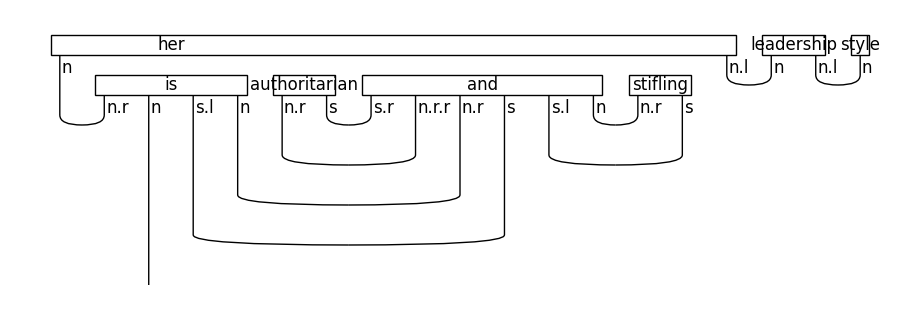

In [16]:
train_diagrams_filter[11].normal_form().draw(figsize=(9, 3), fontsize=12)

Let us compare before and after normal form

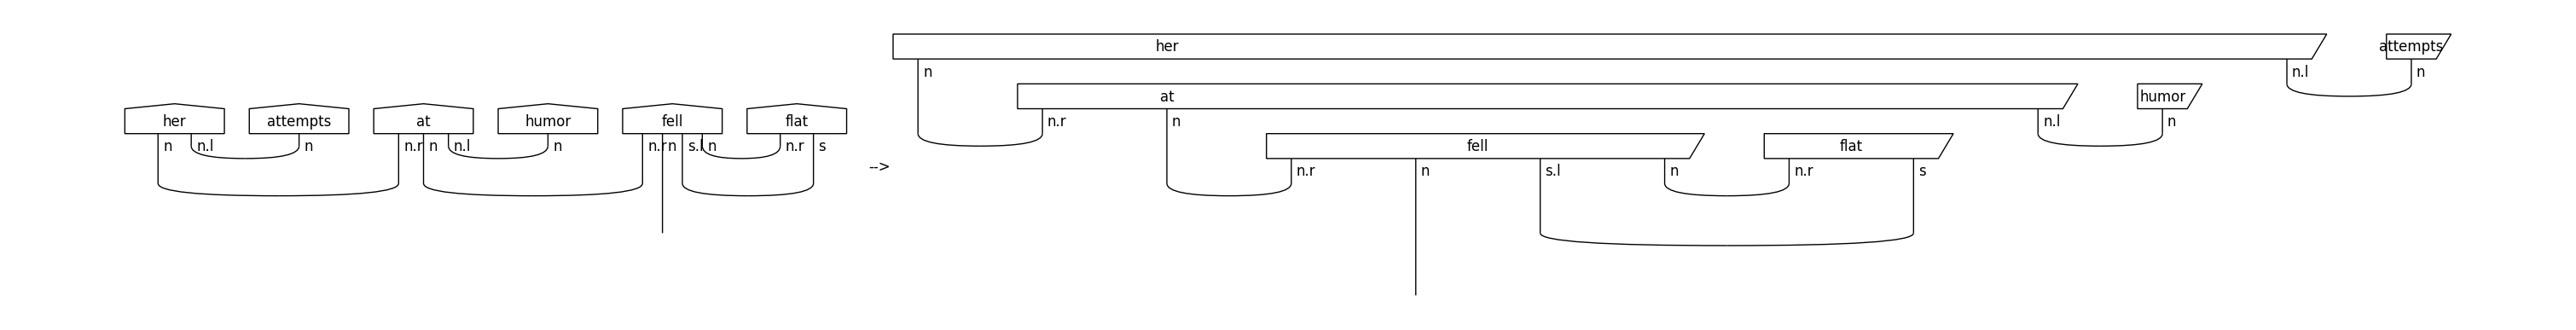

In [18]:
from lambeq.backend import draw_equation

numb = 0
original_diagram = train_diagrams[numb]
normalised_diagram = train_diagrams_filter[numb]

draw_equation(original_diagram, normalised_diagram, symbol='-->', figsize=(30, 6), asymmetry=0.3, fontsize=12)

## Diagram -> Circuit

In [19]:
from lambeq import AtomicType, IQPAnsatz
from lambeq.backend.tensor import Dim

# Define types for the ansatz
noun = AtomicType.NOUN
sentence_type = AtomicType.SENTENCE
prep = AtomicType.PREPOSITIONAL_PHRASE

# Create an ansatz
ansatz = IQPAnsatz({prep:1, noun: 1, sentence_type: 1},n_layers=1,n_single_qubit_params=5)

train_circuits = []
test_circuits =  []

# Create the circuits for the train and test diagrams, and catch any exceptions that might occur,
# Print out the sentences that fail
for index, diag in enumerate(train_diagrams_filter):
    try:
        train_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Train diagram",index, "-> sentence is:", train_dataset.iloc[index,0])
        train_labels[index] = None
        #print(e)

for index,diag in enumerate(test_diagrams_filter):
    try:
        test_circuits.append(ansatz(diag))
    except Exception as e:
        print("Problem with Test diagram",index, "-> sentence is:", test_dataset.iloc[index,0])
        test_labels[index] = None
        #print(e)


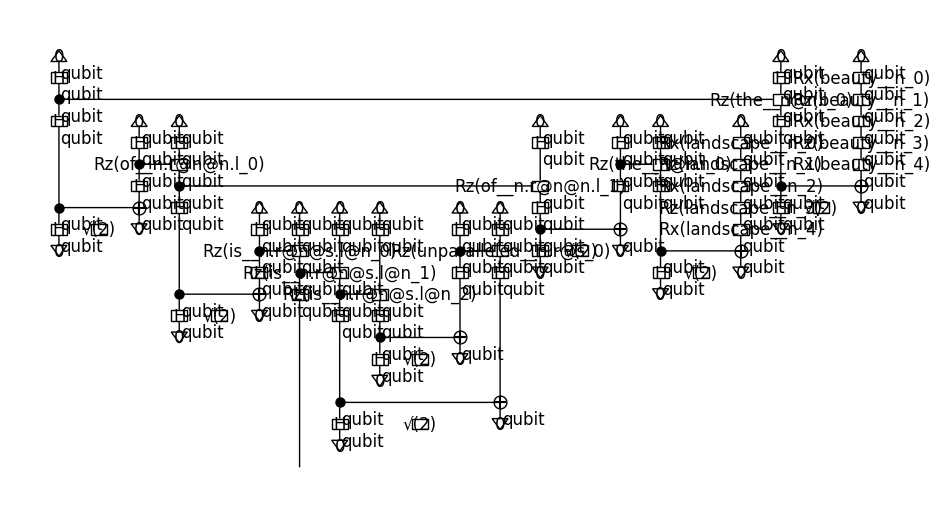

In [23]:
# Let us visualise how the circuits look like
train_circuits[6].draw(figsize=(9, 5), fontsize=12)

In [19]:
# Remove the necessary labels in case of circuit conversion fail
train_labels = remove_none(train_labels)
test_labels = remove_none(test_labels)

In [20]:
print("Number of Train circuits", len(train_circuits), "and labels", len(train_labels), "match? ->", len(train_circuits) == len(train_labels))
print("Number of Test circuits", len(test_circuits), "and labels", len(test_labels), "match? ->", len(test_circuits) == len(test_labels))

Number of Train circuits 198 and labels 198 match? -> True
Number of Test circuits 60 and labels 60 match? -> True


## Training

In this section we will train a model that will predict given a circuit, its sentiment

In [40]:
# Variable definition
BATCH_SIZE = 10
EPOCHS = 70

In [41]:
# Define the accuracy function that will be used for the training
import numpy as np

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y)/2

eval_metrics = {"acc": acc}

In [42]:
# Create the model
from lambeq import NumpyModel

all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [43]:
# Create the trainer that will learn
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import BinaryCrossEntropyLoss

bce = BinaryCrossEntropyLoss(use_jax=True)

trainer = QuantumTrainer(
        model=model,
        loss_function=bce,
        optimizer=SPSAOptimizer,
        optim_hyperparams={'a':0.05, 'c':0.06, 'A':0.001*EPOCHS},
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text')

In [44]:
# Collect the circuit data for convenience
from lambeq import Dataset

new_train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)

new_test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [45]:
# Fit the data to learn and predict given the test circuits
trainer.fit(new_train_dataset, new_test_dataset, eval_interval=1, log_interval=5)

Epoch 5:   train/loss: 1.3875   valid/loss: 1.0560   train/acc: 0.5707   valid/acc: 0.5333
Epoch 10:  train/loss: 1.0802   valid/loss: 0.9645   train/acc: 0.6313   valid/acc: 0.5667
Epoch 15:  train/loss: 0.5487   valid/loss: 0.9147   train/acc: 0.6263   valid/acc: 0.5667
Epoch 20:  train/loss: 0.5578   valid/loss: 0.9390   train/acc: 0.6717   valid/acc: 0.6000
Epoch 25:  train/loss: 0.6295   valid/loss: 0.9408   train/acc: 0.6616   valid/acc: 0.6000
Epoch 30:  train/loss: 0.4469   valid/loss: 0.9503   train/acc: 0.6818   valid/acc: 0.5833
Epoch 35:  train/loss: 0.6991   valid/loss: 0.9554   train/acc: 0.7071   valid/acc: 0.5833
Epoch 40:  train/loss: 0.4252   valid/loss: 0.9351   train/acc: 0.7172   valid/acc: 0.5667
Epoch 45:  train/loss: 0.6961   valid/loss: 0.9127   train/acc: 0.7273   valid/acc: 0.5500
Epoch 50:  train/loss: 0.7716   valid/loss: 0.9886   train/acc: 0.7424   valid/acc: 0.5500
Epoch 55:  train/loss: 0.3356   valid/loss: 0.9253   train/acc: 0.7475   valid/acc: 0.5500

In [46]:
# Print out the accuracy of the prediction for the test dataset 
print(acc(list(model(test_circuits)), test_labels))

0.5666666666666667


Let us now visualise the training with accuracy and loss

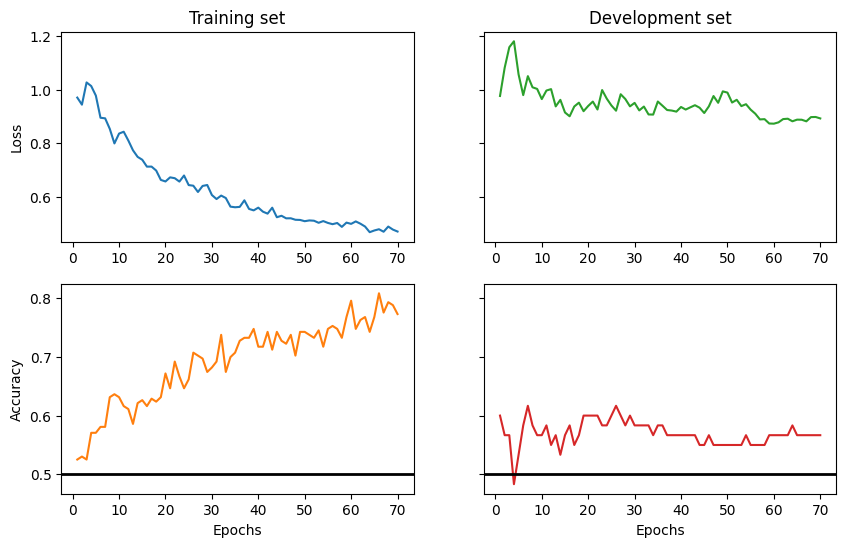

In [47]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

ax_br.axhline(y=0.5, color='black', linewidth=2)
ax_bl.axhline(y=0.5, color='black', linewidth=2)